# Report for mini-project 1

Student: Lucas Gerretsen

Instructor: M. Lepetit

Deadline: 21/12/2018

In [103]:
import mp1
from importlib import reload
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
import numpy as np
import keras
from tqdm import tqdm_notebook as tqdm

print(mp1.IMAGE_SIZE)

72


<module 'mp1' from '/home/lucas/Documents/MVA/DL/MP1/mp1.py'>

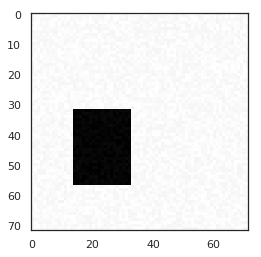

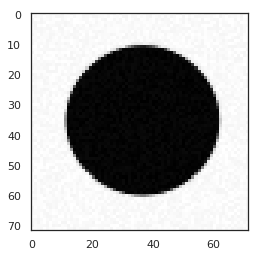

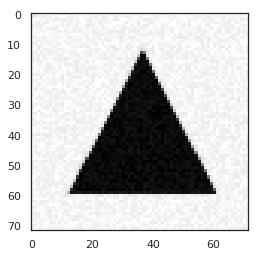

In [153]:
reload(mp1)

## Q3

Our goal here is to train and evaluate a simple linear network on recognizing shapes: rectangle/disk/triangle.

In [139]:
# generate a train set
[X_train, Y_train] = mp1.generate_dataset_classification(300, 20)
Y_train = np.eye(3)[Y_train.astype(int)] # equivalent to keras.utils.np_utils.to_categorical()
print(X_train.shape,Y_train.shape)

Creating data:


Categories: rectangle/disk/triangle
(300, 5184) (300, 3)


In [50]:
# generate a test set
[X_test, Y_test] = mp1.generate_dataset_classification(60, 20)
Y_test = np.eye(3)[Y_test.astype(int)] # equivalent to keras.utils.np_utils.to_categorical()

Creating data:



Categories: rectangle/disk/triangle


In [140]:
# build a 1-layer, dense model
# we perform softmax on the output for this categorization problem and use appropriate loss and metric
model = keras.models.Sequential()
model.add(keras.layers.Dense(3,activation=keras.activations.softmax)) # 3 outputs for the 3 categories
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

In [143]:
model.fit(x=X_train,y=Y_train,epochs=15,batch_size=32,verbose=0)
model.evaluate(X_test,Y_test)

60/60 [==============================] - 0s 367us/step


[0.11027029231190681, 0.9833333333333333]

In [109]:
def reset_weights(model):
    """
    Reset all weights in layers of model by running their initializer
    """
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=keras.backend.get_session())

# parameters for our experiment
n_exp = 3
n_epochs_s = [1,2,3,5,7,10,15]

# record stats - 0 = train/test - 1 = n_epochs - 2 = it_exp
record_loss = np.zeros((2,len(n_epochs_s),n_exp))
record_acc = np.zeros((2,len(n_epochs_s),n_exp))

for it_epochs,epochs in enumerate(tqdm(n_epochs_s)): # test different number of epochs
    for it in range(n_exp): # reproduce the experiment a few times
        # reset the model
        reset_weights(model)
        # train the model
        model.fit(x=X_train,y=Y_train,epochs=epochs,batch_size=32,verbose=0)
        # evaluate the model on train set
        loss,acc = model.evaluate(X_train,Y_train,verbose=0)
        record_loss[0,it_epochs,it] = loss
        record_acc[0,it_epochs,it] = acc
        # evaluate the model on test set
        loss,acc = model.evaluate(X_test,Y_test,verbose=0)
        record_loss[1,it_epochs,it] = loss
        record_acc[1,it_epochs,it] = acc

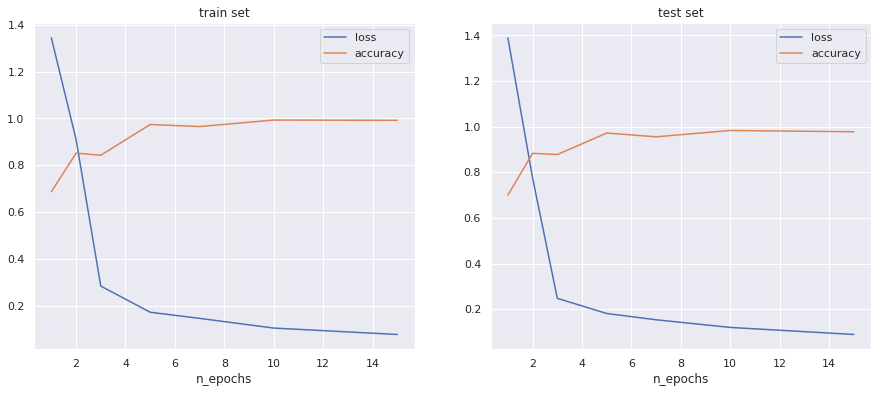

In [151]:
sns.set(style='darkgrid')

plt.figure(figsize=(15,6))

plt.subplot(1,2,1) # plot stats for train set
plt.plot(n_epochs_s,record_loss[0,:,:].mean(axis=1),label='loss')
plt.plot(n_epochs_s,record_acc[0,:,:].mean(axis=1),label='accuracy')
plt.xlabel('n_epochs')
plt.title('train set')
plt.legend()

plt.subplot(1,2,2) # plot stats for test set
plt.plot(n_epochs_s,record_loss[1,:,:].mean(axis=1),label='loss')
plt.plot(n_epochs_s,record_acc[1,:,:].mean(axis=1),label='accuracy')
plt.xlabel('n_epochs')
plt.legend()
plt.title('test set')
plt.show()

As shown in above figures, this simple model is able to learn and discriminate the 3 different shapes (almost perfectly for `n_epochs=10`).

## Q4

We try and vizualize the aspect of the learned kernel associated to each category.

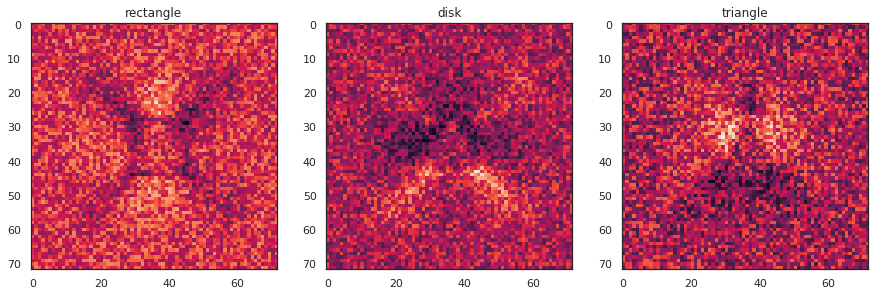

In [154]:
sns.set(style='white')

kernel_weights = np.array(model.get_weights()[0])
IMSIZE = int(mp1.IMAGE_SIZE)

plt.figure(figsize=(15,6))
for category in range(3):
    plt.subplot(1,3,category+1)
    plt.title(mp1.CATEGORIES[category])
    plt.imshow(kernel_weights[:,category].reshape((IMSIZE,IMSIZE)))
plt.show()

Looking at the above figures:
- fig1: we can vizualize in dark tones ditributions of the corners of observed rectangles whose location are specific to that shape as compared to the others
- fig3: we can vizualize in dark tones the same distribution for the triangle
- fig2: this figure, associated to the circle, shows corner locations of both rectangle and triangle in light tones, which suggests that the circle is recognized by elimination 

Note that the kernels are also quite random in the areas that are not discriminative.